In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15476060973695832596
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 17528611527058447927
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 8591421255042219751
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 31595870336
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4878201874569329223
physical_device_desc: "device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:00:06.0, compute capability: 7.0"
]


In [1]:
import os
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

from collections import Counter
from prettytable import PrettyTable
from IPython.display import Image
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve,auc
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import Conv1D, Add, MaxPooling1D, BatchNormalization 
from tensorflow.keras.layers import Embedding, Bidirectional, GlobalMaxPooling1D
from tensorflow.python.keras.layers.recurrent import LSTM
from tensorflow.keras.optimizers import Adam
# CuDNNLSTM error; The error was because from TensorFlow 2 you do not need to specify CuDNNLSTM. 
# You can just use LSTM with no activation function and it will automatically use the CuDNN version. You do have to install CuDNN first.

from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import pickle5 as pickle

In [2]:
# For PWS
with open( '/mnt/vdb/thesis/pwm/AMPnonAMP.sim60_c08.pssm.pkl', 'rb') as file:
    AMPs_df = pickle.load(file)

In [2]:

with open( "/mnt/vdb/thesis/jax/AMPNonAMP.V5_C08_sim60.reps", 'rb') as file:
    AMPs_df = pickle.load(file)

In [4]:
#AMPs_df.drop_duplicates(subset=['Sequence'],inplace=True)
AMPs_df

,ID,length,class,reps
261,0_antitbpred|antitbpred,33,0,"[0.021885789930820465, 0.06677412241697311, 0...."
17,0_peptideDB.anti|peptideDB.anti,148,0,"[0.00609204825013876, -0.07883947342634201, 0...."
226,1000_pos_train_ds3|pos_train_ds3,86,0,"[0.012824639678001404, 0.0021224096417427063, ..."
302,10023_dbaasp|dbaasp_peptides,36,0,"[0.003721927758306265, -0.07121428847312927, -..."
60,"1003,1011,1019,1027,1035|CancerPPD_l_natural",20,0,"[0.02940366230905056, 0.001728760078549385, -0..."
...,...,...,...,...
456,tagenome__1003787_1003787.scaffolds.fasta_scaf...,47,0,"[0.019306708127260208, -0.030069835484027863, ..."
171,tagenome__1003787_1003787.scaffolds.fasta_scaf...,60,0,"[0.011303016915917397, -0.07055054605007172, 0..."
283,tagenome__1003787_1003787.scaffolds.fasta_scaf...,58,0,"[0.014870524406433105, -0.13572746515274048, 0..."
148,tagenome__1003787_1003787.scaffolds.fasta_scaf...,56,0,"[0.010077092796564102, -0.07801175117492676, 0..."


### Utility function: plot_history, display_model_score

In [2]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score
from matplotlib import pyplot

def create_roc_curve(labels, scores):
    fpr, tpr, thresholds = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)  

    plt.title('Receiver Operating Characteristic' )
    plt.plot(fpr, tpr, 'b', label='AUC = %0.2f'% roc_auc)

    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.2])
    plt.ylim([-0.1,1.2])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.show()

# plot no skill and model precision-recall curves
def plot_pr_curve(test_y, model_probs):
    precision, recall, _ = precision_recall_curve(test_y, model_probs)
    auc_score = auc(recall, precision)
    # calculate the no skill line as the proportion of the positive class
    no_skill = len(test_y[test_y==1]) / len(test_y)
    pyplot.title('2-class Precision-Recall curve')
    # plot the no skill precision-recall curve
    pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    # plot model precis|ion-recall curve
    precision, recall, _ = precision_recall_curve(test_y, model_probs)
    pyplot.plot(recall, precision, marker='.', label='Model AUC = %0.2f'% auc_score)
    # axis labels
    pyplot.xlabel('Recall')
    pyplot.ylabel('Precision')
    # show the legend
    pyplot.legend()
    # show the plot
    pyplot.show()

In [3]:
def plot_history(history):
  # dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  x = range(1, len(acc) + 1)

  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.plot(x, acc, 'b', label='Training acc')
  plt.plot(x, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(x, loss, 'b', label='Training loss')
  plt.plot(x, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

# Display model score(Loss & Accuracy) across all sets.
def display_model_score(model, train, val, test):
  train_score = model.evaluate(train[0], train[1], verbose=1)
  print('Train loss: ', train_score[0])
  print('Train accuracy: ', train_score[1])
  print('-'*70)
  val_score = model.evaluate(val[0], val[1], verbose=1)
  print('Val loss: ', val_score[0])
  print('Val accuracy: ', val_score[1])
  print('-'*70)
  test_score = model.evaluate(test[0], test[1], verbose=1)
  print('Test loss: ', test_score[0])
  print('Test accuracy: ', test_score[1])

def plot_history_CV(cv, estimator,x,y):
  # plot arrows
  fig1 = plt.figure(figsize=[12,12])
  ax1 = fig1.add_subplot(111,aspect = 'equal')
  ax1.add_patch(
      patches.Arrow(0.45,0.5,-0.25,0.25,width=0.3,color='green',alpha = 0.5)
      )
  ax1.add_patch(
      patches.Arrow(0.5,0.45,0.25,-0.25,width=0.3,color='red',alpha = 0.5)
      )

  tprs = []
  aucs = []
  mean_fpr = np.linspace(0,1,100)
  i = 1
  for train,test in cv.split(x,y):
      model = create_Modelbaseline()
      model.fit(x[train],y.iloc[train],
            epochs=30,
            shuffle=True,verbose=0)
      prediction = model.predict(x[test])
      fpr, tpr, t = roc_curve(y[test], prediction[:, 1])
      tprs.append(interp(mean_fpr, fpr, tpr))
      roc_auc = auc(fpr, tpr)
      aucs.append(roc_auc)
      plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
      i= i+1

  plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
  mean_tpr = np.mean(tprs, axis=0)
  mean_auc = auc(mean_fpr, mean_tpr)
  plt.plot(mean_fpr, mean_tpr, color='blue',
          label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)

  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC')
  plt.legend(loc="lower right")
  plt.text(0.32,0.7,'More accurate area',fontsize = 12)
  plt.text(0.63,0.4,'Less accurate area',fontsize = 12)
  plt.show()

# Split Train/ Test / Validation set

In [11]:
# For PWM -400 dimension

Y1 =np.array([0] * 68869 + [1] * 68520)
X_train, X_test, y_train, y_test = train_test_split(AMPs_df, Y1, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [7]:
input_shape  = X.shape
input_shape

(88692, 1900)

In [16]:
#X= np.array(AMPs_df['reps'].to_list())
#y= np.array(AMPs_df['class'].to_list())
X_train, X_test, y_train, y_test = train_test_split(np.array(AMPs_df['reps'].to_list()), np.array(AMPs_df['class'].to_list()), test_size=0.2, random_state=42, shuffle= True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, shuffle= True) # 0.25 x 0.8 = 0.2

In [17]:
# Given data size
print('Train size: ', len(X_train))
print('Val size: ', len(X_val))
print('Test size: ', len(X_test))

Train size:  51873
Val size:  17292
Test size:  17292


# Model 1: Our simple model 

## Keras

In [13]:
def create_Modelbaseline():
  x_input = Input(shape=(1900,))
  layer_0 = Dense(1600)(x_input)
  dropout_0 = BatchNormalization()(layer_0)
  layer_1 = Dense(1200)(dropout_0)
  dropout_1 = BatchNormalization()(layer_1)
  layer_2 = Dense(800)(dropout_1)
  dropout_2 = Dropout(0.5)(layer_2)
  layer_3 = Dense(512)(dropout_2)
  dropout_3 = Dropout(0.5)(layer_3)
  x_output = Dense(1, activation='sigmoid', name='output_layer')(dropout_3)

  model = Model(inputs=x_input, outputs=x_output)
  model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
  return model

In [14]:
 model = create_Modelbaseline()
 model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1900)]            0         
_________________________________________________________________
dense_9 (Dense)              (None, 1600)              3041600   
_________________________________________________________________
batch_normalization_2 (Batch (None, 1600)              6400      
_________________________________________________________________
dense_10 (Dense)             (None, 1200)              1921200   
_________________________________________________________________
batch_normalization_3 (Batch (None, 1200)              4800      
_________________________________________________________________
dense_11 (Dense)             (None, 800)               960800    
_________________________________________________________________
dropout_7 (Dropout)          (None, 800)              

In [4]:
#from keras import backend as K
#K.set_value(model_ProtCNN.optimizer.learning_rate, 0.00001)
def lr_schedule(epoch):
    
    lr = 1e-3
    if epoch > 80:
        lr = 0.1e-6
    elif epoch > 50:    
        lr = 0.3e-5
    elif epoch > 20:
        lr = 1e-4
        
    print(' Learning rate: ', lr)    
    return lr 


# Early Stopping
es = EarlyStopping(monitor='val_loss', patience=15, verbose=1)

#learning rate decay
lr_scheduler = LearningRateScheduler(lr_schedule)

In [16]:
checkpoint = ModelCheckpoint("our_best_model.hdf5", monitor='val_accuracy', verbose=1,
    save_best_only=True, mode='auto', period=1)

history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val),
                     callbacks=[lr_scheduler,es], verbose=2)


 Learning rate:  0.001
Epoch 1/100
2577/2577 - 9s - loss: 0.6304 - accuracy: 0.8112 - val_loss: 0.3955 - val_accuracy: 0.8451
 Learning rate:  0.001
Epoch 2/100
2577/2577 - 8s - loss: 0.3763 - accuracy: 0.8482 - val_loss: 0.3233 - val_accuracy: 0.8646
 Learning rate:  0.001
Epoch 3/100
2577/2577 - 8s - loss: 0.3628 - accuracy: 0.8551 - val_loss: 0.3210 - val_accuracy: 0.8682
 Learning rate:  0.001
Epoch 4/100
2577/2577 - 8s - loss: 0.3402 - accuracy: 0.8629 - val_loss: 0.3486 - val_accuracy: 0.8537
 Learning rate:  0.001
Epoch 5/100
2577/2577 - 8s - loss: 0.3295 - accuracy: 0.8657 - val_loss: 0.3159 - val_accuracy: 0.8683
 Learning rate:  0.001
Epoch 6/100
2577/2577 - 9s - loss: 0.3235 - accuracy: 0.8691 - val_loss: 0.3194 - val_accuracy: 0.8782
 Learning rate:  0.001
Epoch 7/100
2577/2577 - 9s - loss: 0.3193 - accuracy: 0.8710 - val_loss: 0.3013 - val_accuracy: 0.8775
 Learning rate:  0.001
Epoch 8/100
2577/2577 - 8s - loss: 0.3148 - accuracy: 0.8719 - val_loss: 0.2943 - val_accuracy:

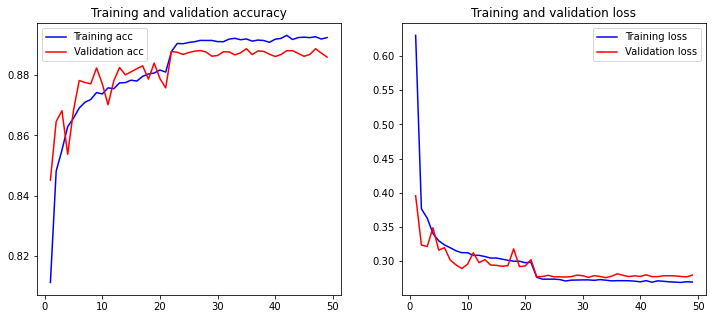

In [17]:
plot_history(history)

Overfitting if: training loss >> validation loss, training loss much greater than validation loss.

Underfitting if: training loss << validation loss, training loss much less than validation loss. 

In [18]:
display_model_score(model,
    [X_train, y_train],
    [X_val, y_val],
    [X_test, y_test])

2577/2577 [==============================] - 4s 1ms/step - loss: 0.2621 - accuracy: 0.8958
Train loss:  0.2621147334575653
Train accuracy:  0.895794153213501
----------------------------------------------------------------------
859/859 [==============================] - 1s 2ms/step - loss: 0.2792 - accuracy: 0.8860
Val loss:  0.2792086899280548
Val accuracy:  0.8859815001487732
----------------------------------------------------------------------
859/859 [==============================] - 1s 2ms/step - loss: 0.2820 - accuracy: 0.8867
Test loss:  0.28201717138290405
Test accuracy:  0.8866729736328125


In [19]:
y_probas = model.predict(X_test)

In [20]:
threshold = 0.5
y_predict = np.where(y_probas > threshold, 1, 0)

print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.88      0.90      0.89     13856
           1       0.89      0.87      0.88     13622

    accuracy                           0.89     27478
   macro avg       0.89      0.89      0.89     27478
weighted avg       0.89      0.89      0.89     27478



ROC area is 0.9004177329657576


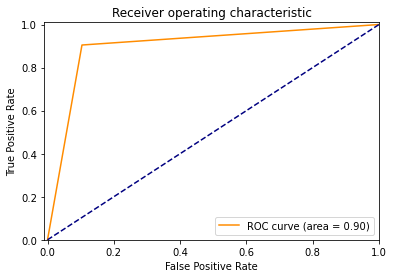

In [28]:
from sklearn.metrics import roc_curve, auc
# probs from log preds
# probs = np.exp(preds[:,1])
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_predict, pos_label=1)

# Compute ROC area
roc_auc = auc(fpr, tpr)
print('ROC area is {0}'.format(roc_auc))
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

# Cross validation with whole dataset

In [21]:

estimator = KerasClassifier(build_fn=create_Modelbaseline, epochs=100,verbose=0)
kfold = StratifiedKFold(n_splits=5, shuffle=True)
results = cross_val_score(estimator, X, y, cv=kfold)

In [22]:
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 89.40% (0.35%)


In [ ]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scoring = ['accuracy', 'f1', 'roc_auc', 'recall', 'precision','neg_log_loss']
scores = cross_validate(estimator, X, y, scoring=scoring, cv=kfold, return_train_score=True)
print("Accuracy TEST: %0.2f (+/- %0.2f) Accuracy TRAIN: %0.2f (+/- %0.2f)" %
      (scores['test_accuracy'].mean(), scores['test_accuracy'].std() * 2, scores['train_accuracy'].mean(), scores['train_accuracy'].std() * 2))
print("F1 TEST: %0.2f (+/- %0.2f) F1 TRAIN : %0.2f (+/- %0.2f) " %
      (scores['test_f1'].mean(), scores['test_f1'].std() * 2, scores['train_f1'].mean(), scores['train_f1'].std() * 2))
print("AUROC TEST: %0.2f (+/- %0.2f) AUROC TRAIN : %0.2f (+/- %0.2f)" %
      (scores['test_roc_auc'].mean(), scores['test_roc_auc'].std() * 2, scores['train_roc_auc'].mean(), scores['train_roc_auc'].std() * 2))
print("recall TEST: %0.2f (+/- %0.2f) recall TRAIN: %0.2f (+/- %0.2f)" %
      (scores['test_recall'].mean(), scores['test_recall'].std() * 2, scores['train_recall'].mean(), scores['train_recall'].std() * 2))
print("Precision TEST: %0.2f (+/- %0.2f) Precision TRAIN: %0.2f (+/- %0.2f)" %
      (scores['test_precision'].mean(), scores['test_precision'].std() * 2, scores['train_precision'].mean(), scores['train_precision'].std() * 2))
print("Log loss TEST: %0.2f (+/- %0.2f) Log loss TRAIN: %0.2f (+/- %0.2f)" %
      (scores['test_neg_log_loss'].mean(), scores['test_neg_log_loss'].std() * 2, scores['train_neg_log_loss'].mean(), scores['train_neg_log_loss'].std() * 2))

# Model 2: Bidirectional LSTM
(The perforamnce did not good)

The below models are from https://towardsdatascience.com/protein-sequence-classification-99c80d0ad2df

https://stackoverflow.com/questions/38714959/understanding-keras-lstms

Embedding
* https://towardsdatascience.com/neural-network-embeddings-explained-4d028e6f0526

must specify 3 arguments:

    input_dim: This is the size of the vocabulary in the text data. For example, if your data is integer encoded to values between 0-10, then the size of the vocabulary would be 11 words.
    output_dim: This is the size of the vector space in which words will be embedded. It defines the size of the output vectors from this layer for each word. For example, it could be 32 or 100 or even larger. Test different values for your problem.
    input_length: This is the length of input sequences, as you would define for any input layer of a Keras model. For example, if all of your input documents are comprised of 1000 words, this would be 1000.


Input LSTM 
https://github.com/MohammadFneish7/Keras_LSTM_Diagram

(No batches , Timeesteps , no features)

In [13]:
import numpy as np
# https://stackoverflow.com/questions/52803989/how-to-correct-shape-of-keras-input-into-a-3d-array/52804200
X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))
print(X_train.shape)
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
print(X_test.shape)
X_val = np.reshape(X_val,(X_val.shape[0],X_val.shape[1],1))
print(X_val.shape)

(82433, 400, 1)
(27478, 400, 1)
(27478, 400, 1)


In [8]:
x_input = Input( shape=(1900,1) )

Keras - ImportError: cannot import name 'CuDNNLSTM'

 To slove : for Tensorflow-2: You can just use LSTM with no activation function and it will automatically use the CuDNN version

* https://stackoverflow.com/questions/48086014/keras-model-with-cudnnlstm-layers-doesnt-work-on-production-server
* https://forums.developer.nvidia.com/t/importerror-cannot-import-name-cudnnlstm-from-tensorflow-keras-layers/82778
 

In [7]:
x_input = Input( shape=(1900,1) )

#initial conv
conv = Conv1D(256, 9,padding='same', activation = 'relu')(x_input) 

#conv = BatchNormalization()(conv)
x = MaxPooling1D(4)(conv)
x = Dropout(0.2)(x)


flat = Flatten()(x)

bi_rnn =  LSTM(64, return_sequences=True ) (x)
x = Dropout(0.2)(bi_rnn)
#x = Bidirectional( LSTM(128, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01)
#                        , bias_regularizer=l2(0.01), return_sequences=False, stateful=False ) )(x)

flat = Flatten()(x)
layer_3 = Dense(1984, activation='relu')(flat)
dropout_3 = Dropout(0.2)(layer_3)
layer_3 = Dense(256, activation='relu')(layer_3)
# softmax classifier
x_output = Dense(1, activation='sigmoid', name='output_layer')(layer_3)

model_BLSTM = Model(inputs=x_input, outputs=x_output)
model_BLSTM.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_BLSTM.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1900, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 1900, 256)         2560      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 475, 256)          0         
_________________________________________________________________
dropout (Dropout)            (None, 475, 256)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 475, 64)           82176     
_________________________________________________________________
dropout_1 (Dropout)          (None, 475, 64)           0         
_________________________________________________________________
flatten (Flatten)            (None, 30400)            

In [15]:
# Model III

x_input = Input( shape=(1900,1) )

#Conv1D
conv = Conv1D(64, kernel_size=40, strides=1, padding='same', activation='relu')(x_input)  # Extract whole motif pattern
conv = MaxPooling1D(pool_size=25)(conv)
conv = Conv1D(128, kernel_size=7, strides=1, padding='same', activation='relu')(conv)  # Extract extra features  
conv = MaxPooling1D(pool_size=4)(conv)

# batch normalization on features
#conv = BatchNormalization()(conv)

# Dropout and Dense Layer before LSTM
layer = Dense(1211, activation='relu')(conv)
dense_convinpn = Dropout(0.5)(layer)


# Bi-LSTM
lstm = Bidirectional(LSTM(64, return_sequences=True, name='bilstm'))(dense_convinpn) # learn order of sequence
drop_after_lstm = Dropout(0.5)(lstm)

# Dense out
output = Flatten()(drop_after_lstm)
x_output = Dense(1, activation='sigmoid')(output)

# comple
model_BLSTM = Model(inputs=x_input, outputs=x_output)
model_BLSTM.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_BLSTM.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1900, 1)]         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1900, 64)          2624      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 76, 64)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 76, 128)           57472     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 19, 128)           0         
_________________________________________________________________
dense_3 (Dense)              (None, 19, 1211)          156219    
_________________________________________________________________
dropout_2 (Dropout)          (None, 19, 1211)         

In [14]:
x_input = Input( shape=(1900,1) )

#Conv1D
conv = Conv1D(64, kernel_size=40, strides=1, padding='same', activation='relu')(x_input)  # Extract whole motif pattern
conv = MaxPooling1D(pool_size=25)(conv)
conv = Conv1D(128, kernel_size=7, strides=1, padding='same', activation='relu')(conv)  # Extract extra features  
conv = MaxPooling1D(pool_size=4)(conv)

# batch normalization on features
#conv = BatchNormalization()(conv)

# Dropout and Dense Layer before LSTM
layer = Dense(1211, activation='relu')(conv)
dense_convinpn = Dropout(0.5)(layer)


# Bi-LSTM
lstm = Bidirectional(LSTM(64, return_sequences=True, name='bilstm'))(dense_convinpn) # learn order of sequence
drop_after_lstm = Dropout(0.5)(lstm)

# Dense out
output = Flatten()(drop_after_lstm)
output = BatchNormalization()(output)
output = Dense(1211, activation='relu')(output)
x_output = Dense(1, activation='sigmoid')(output)

# comple
model_BLSTM = Model(inputs=x_input, outputs=x_output)
model_BLSTM.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_BLSTM.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 400, 1)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 400, 64)           2624      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 16, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16, 128)           57472     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 4, 128)            0         
_________________________________________________________________
dense (Dense)                (None, 4, 1211)           156219    
_________________________________________________________________
dropout (Dropout)            (None, 4, 1211)          

In [8]:
#from keras import backend as K
#K.set_value(model_ProtCNN.optimizer.learning_rate, 0.00001)
def lr_schedule(epoch):
    
    lr = 1e-3
    if epoch > 80:
        lr = 0.1e-6
    elif epoch > 50:    
        lr = 0.3e-5
    elif epoch > 20:
        lr = 1e-4
        
    print(' Learning rate: ', lr)    
    return lr 

#learning rate decay
lr_scheduler = LearningRateScheduler(lr_schedule)

In [16]:
checkpoint_BLSTM = ModelCheckpoint("/mnt/vdb/thesis/best_model_BLSTM.4.hdf5", monitor='loss', verbose=1,
    save_best_only=True, mode='auto', period=1)

# Early Stopping
es = EarlyStopping(monitor='val_loss', patience=15, verbose=1)

history_BLSTM = model_BLSTM.fit(X_train, y_train, epochs=100, batch_size=256, validation_data=(X_val, y_val),
                     callbacks=[es,lr_scheduler], verbose=1)

 Learning rate:  0.001
Epoch 1/100
323/323 [==============================] - 38s 117ms/step - loss: 0.4405 - accuracy: 0.7768 - val_loss: 0.3651 - val_accuracy: 0.8402
 Learning rate:  0.001
Epoch 2/100
323/323 [==============================] - 36s 113ms/step - loss: 0.3037 - accuracy: 0.8735 - val_loss: 0.2869 - val_accuracy: 0.8800
 Learning rate:  0.001
Epoch 3/100
323/323 [==============================] - 38s 116ms/step - loss: 0.2779 - accuracy: 0.8860 - val_loss: 0.3662 - val_accuracy: 0.8458
 Learning rate:  0.001
Epoch 4/100
323/323 [==============================] - 37s 115ms/step - loss: 0.2945 - accuracy: 0.8766 - val_loss: 0.3836 - val_accuracy: 0.8542
 Learning rate:  0.001
Epoch 5/100
323/323 [==============================] - 37s 114ms/step - loss: 0.2861 - accuracy: 0.8796 - val_loss: 0.2627 - val_accuracy: 0.8903
 Learning rate:  0.001
Epoch 6/100
323/323 [==============================] - 37s 113ms/step - loss: 0.2407 - accuracy: 0.9044 - val_loss: 0.2604 - val_acc

In [21]:
model_BLSTM.save('/mnt/vdb/thesis/best_model_BLSTM.V5.h5') 

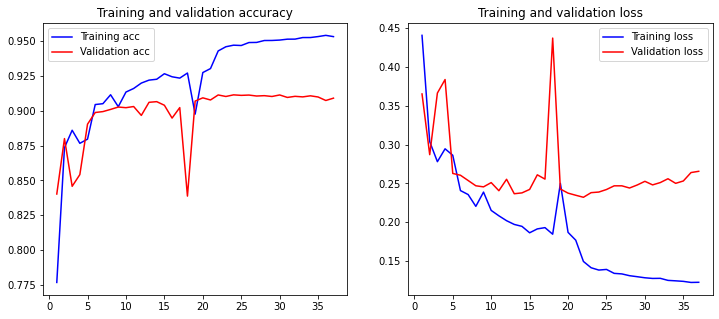

In [18]:
plot_history(history_BLSTM)

In [19]:
display_model_score(model_BLSTM,
    [X_train, y_train],
    [X_val, y_val],
    [X_test, y_test])

2577/2577 [==============================] - 32s 12ms/step - loss: 0.1122 - accuracy: 0.9581
Train loss:  0.1122024655342102
Train accuracy:  0.958087146282196
----------------------------------------------------------------------
859/859 [==============================] - 11s 12ms/step - loss: 0.2655 - accuracy: 0.9090
Val loss:  0.26550421118736267
Val accuracy:  0.9090180993080139
----------------------------------------------------------------------
859/859 [==============================] - 10s 12ms/step - loss: 0.2770 - accuracy: 0.9076
Test loss:  0.2770465612411499
Test accuracy:  0.9075987935066223


In [20]:
y_probas = model_BLSTM.predict(X_test)
threshold = 0.5
y_predict = np.where(y_probas > threshold, 1, 0)
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91     13856
           1       0.91      0.90      0.91     13622

    accuracy                           0.91     27478
   macro avg       0.91      0.91      0.91     27478
weighted avg       0.91      0.91      0.91     27478



(42856, 19, 1)

In [83]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93     21596
           1       0.93      0.93      0.93     21260

    accuracy                           0.93     42856
   macro avg       0.93      0.93      0.93     42856
weighted avg       0.93      0.93      0.93     42856



## PWM
```
You don't need to restructure anything at all to get the output of a Conv1D layer into an LSTM layer.

So, the problem is simply the presence of the Flatten layer, which destroys the shape.

These are the shapes used by Conv1D and LSTM:

Conv1D: (batch, length, channels)
LSTM: (batch, timeSteps, features)
Length is the same as timeSteps, and channels is the same as features.

Using the Bidirectional wrapper won't change a thing either. It will only duplicate your output features.

Classifying.
If you're going to classify the entire sequence as a whole, your last LSTM must use return_sequences=False. (Or you may use some flatten + dense instead after)

If you're going to classify each step of the sequence, all your LSTMs should have return_sequences=True. You should not flatten the data after them.
```

In [68]:
x_input = Input( shape=(400,1) )

#Conv1D
conv = Conv1D(64, kernel_size=40, padding='same', activation='relu')(x_input)  # Extract whole motif pattern
conv = MaxPooling1D(pool_size=25)(conv)
conv = Conv1D(128, kernel_size=7, padding='same', activation='relu')(conv)  # Extract extra features  
conv = MaxPooling1D(pool_size=4)(conv)

# batch normalization on features
#conv = BatchNormalization()(conv)

# Dropout and Dense Layer before LSTM
#conv = Dense(1211, activation='relu')(conv)
#conv = Dropout(0.5)(conv)


# Bi-LSTM
lstm = Bidirectional(LSTM(64, return_sequences=True, name='bilstm'))(conv) # learn order of sequence
lstm = Dropout(0.5)(lstm)

# Dense out
output = Flatten()(lstm)
output = Dense(1211, activation='relu')(output)
output = BatchNormalization()(output)
output = Dense(1211, activation='relu')(output)
output = Dropout(0.5)(output)
x_output = Dense(1, activation='sigmoid')(output)

# comple
model_BLSTM = Model(inputs=x_input, outputs=x_output)
model_BLSTM.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_BLSTM.summary()

Model: "functional_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        [(None, 400, 1)]          0         
_________________________________________________________________
conv1d_52 (Conv1D)           (None, 400, 64)           2624      
_________________________________________________________________
max_pooling1d_52 (MaxPooling (None, 16, 64)            0         
_________________________________________________________________
conv1d_53 (Conv1D)           (None, 16, 128)           57472     
_________________________________________________________________
max_pooling1d_53 (MaxPooling (None, 4, 128)            0         
_________________________________________________________________
bidirectional_26 (Bidirectio (None, 4, 128)            98816     
_________________________________________________________________
dropout_47 (Dropout)         (None, 4, 128)          

In [69]:
checkpoint_BLSTM = ModelCheckpoint("/mnt/vdb/thesis/best_model_BLSTM.V5.hdf5", monitor='loss', verbose=1,
    save_best_only=True, mode='auto', period=1)

# Early Stopping
es = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

history_BLSTM = model_BLSTM.fit(X_train, y_train, epochs=100, batch_size=256, validation_data=(X_val, y_val),
                     callbacks=[es,checkpoint_BLSTM,lr_scheduler], verbose=1)

 Learning rate:  0.001
Epoch 1/100
201/203 [============================>.] - ETA: 0s - loss: 0.6873 - accuracy: 0.5248
Epoch 00001: loss improved from inf to 0.68716, saving model to /mnt/vdb/thesis/best_model_BLSTM.V5.hdf5
203/203 [==============================] - 6s 31ms/step - loss: 0.6872 - accuracy: 0.5252 - val_loss: 0.6943 - val_accuracy: 0.5041
 Learning rate:  0.001
Epoch 2/100
202/203 [============================>.] - ETA: 0s - loss: 0.5949 - accuracy: 0.6568
Epoch 00002: loss improved from 0.68716 to 0.59497, saving model to /mnt/vdb/thesis/best_model_BLSTM.V5.hdf5
203/203 [==============================] - 6s 27ms/step - loss: 0.5950 - accuracy: 0.6569 - val_loss: 0.6285 - val_accuracy: 0.6584
 Learning rate:  0.001
Epoch 3/100
202/203 [============================>.] - ETA: 0s - loss: 0.5488 - accuracy: 0.7073
Epoch 00003: loss improved from 0.59497 to 0.54890, saving model to /mnt/vdb/thesis/best_model_BLSTM.V5.hdf5
203/203 [==============================] - 6s 28ms/st

In [70]:
y_probas = model_BLSTM.predict(X_test)
threshold = 0.5
y_predict = np.where(y_probas > threshold, 1, 0)
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67      8722
           1       0.00      0.00      0.00      8570

    accuracy                           0.50     17292
   macro avg       0.25      0.50      0.34     17292
weighted avg       0.25      0.50      0.34     17292



/home/ubuntu/miniconda3/envs/py3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/miniconda3/envs/py3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/miniconda3/envs/py3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [71]:
display_model_score(model_BLSTM,
    [X_train, y_train],
    [X_val, y_val],
    [X_test, y_test])

1622/1622 [==============================] - 6s 4ms/step - loss: 1.2964 - accuracy: 0.4987
Train loss:  1.296425461769104
Train accuracy:  0.4986601769924164
----------------------------------------------------------------------
541/541 [==============================] - 2s 4ms/step - loss: 1.2978 - accuracy: 0.4992
Val loss:  1.297782063484192
Val accuracy:  0.499248206615448
----------------------------------------------------------------------
541/541 [==============================] - 2s 4ms/step - loss: 1.2841 - accuracy: 0.5044
Test loss:  1.284087061882019
Test accuracy:  0.504395067691803


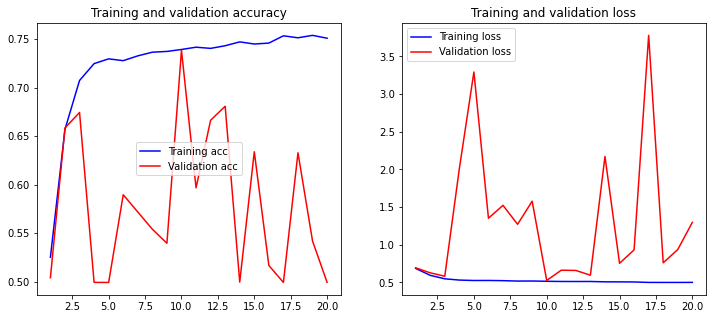

In [72]:
plot_history(history_BLSTM)

In [21]:
model_BLSTM.save('/mnt/vdb/thesis/best_model_BLSTM.V5.h5') 

# Training set 2

### set9 PSSM

In [13]:
with open( "/mnt/vdb/thesis/trainingset2/set9/pssm/AMP/AMP.pssm.plk", 'rb') as file:
    AMPs_df = pickle.load(file)
AMPs_df["class"] = 0
with open( "/mnt/vdb/thesis/trainingset2/set9/pssm/nonAMP/nonAMP.pssm.plk", 'rb') as file:
    nonAMPs_df = pickle.load(file)   
nonAMPs_df["class"] = 1

AMPNonAMP_df = pd.concat([AMPs_df, nonAMPs_df], ignore_index=True)

#AMPs_df = AMPs_df[AMPs_df["length"] <= 300 ]
with open( "../datasets/thesis/trainingset2/benchmark_set/AMPnonAMP.pssm.pkl", 'rb') as file:
    benchmark_AMPs_df = pickle.load(file)
    
X_train = np.array(AMPNonAMP_df['reps'].to_list())
y_train = np.array(AMPNonAMP_df['class'].to_list())
X_test = np.array(benchmark_AMPs_df["reps"].to_list())
y_test = np.array( benchmark_AMPs_df["class"].to_list())
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))
print(X_train.shape)
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
print(X_test.shape)
X_val = np.reshape(X_val,(X_val.shape[0],X_val.shape[1],1))
print(X_val.shape)

(56620, 400, 1)
(3556, 400, 1)
(14155, 400, 1)


## SET 9

In [ ]:
import pickle5 as pickle
with open( "/mnt/vdb/thesis/trainingset2/set9/jax/AMPNonAMP.reps", 'rb') as file:
    AMPNonAMP_df = pickle.load(file)
with open( "/mnt/vdb/thesis/trainingset2/benchmark_set/jax/AMPNonAMP.benchmark_set.reps", 'rb') as file:
    benchmark_AMPs_df = pickle.load(file)
    
X_train = np.array(AMPNonAMP_df['reps'].to_list())
y_train = np.array(AMPNonAMP_df['class'].to_list())
X_test = np.array(benchmark_AMPs_df["reps"].to_list())
y_test = np.array( benchmark_AMPs_df["class"].to_list())

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))
print(X_train.shape)
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
print(X_test.shape)
X_val = np.reshape(X_val,(X_val.shape[0],X_val.shape[1],1))
print(X_val.shape)

In [5]:
def create_Modelbaseline_pssm():
    x_input = Input( shape=(400,1) )

    #Conv1D
    conv = Conv1D(64, kernel_size=40, strides=1, padding='same', activation='relu')(x_input)  # Extract whole motif pattern
    conv = MaxPooling1D(pool_size=25)(conv)
    conv = Conv1D(128, kernel_size=7, strides=1, padding='same', activation='relu')(conv)  # Extract extra features  
    conv = MaxPooling1D(pool_size=4)(conv)

    # batch normalization on features
    #conv = BatchNormalization()(conv)

    # Dropout and Dense Layer before LSTM
    layer = Dense(1211, activation='relu')(conv)
    #dense_convinpn = Dropout(0.5)(layer)


    # Bi-LSTM
    lstm = Bidirectional(LSTM(64, return_sequences=True, name='bilstm'))(layer) # learn order of sequence
    #drop_after_lstm = Dropout(0.5)(lstm)

    # Dense out
    output = Flatten()(lstm)
    #output = Dropout(0.5)(output)
    output = BatchNormalization()(output)
    output = Dense(1211, activation='relu')(output)
    output = BatchNormalization()(output)
    output = Dense(1211, activation='relu')(output)
    output = BatchNormalization()(output)
    x_output = Dense(1, activation='sigmoid')(output)

    # comple
    model_BLSTM = Model(inputs=x_input, outputs=x_output)
    model_BLSTM.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model_BLSTM

def create_Modelbaseline_jax():
    x_input = Input( shape=(1900,1) )
    #Conv1D
    conv = Conv1D(64, kernel_size=40, strides=1, padding='same', activation='relu')(x_input)  # Extract whole motif pattern
    conv = MaxPooling1D(pool_size=25)(conv)
    conv = Conv1D(128, kernel_size=7, strides=1, padding='same', activation='relu')(conv)  # Extract extra features  
    conv = MaxPooling1D(pool_size=4)(conv)

    # batch normalization on features
    #conv = BatchNormalization()(conv)

    # Dropout and Dense Layer before LSTM
    layer = Dense(1211, activation='relu')(conv)
    #dense_convinpn = Dropout(0.5)(layer)

    # Bi-LSTM
    lstm = Bidirectional(LSTM(64, return_sequences=True, name='bilstm'))(layer) # learn order of sequence
    #drop_after_lstm = Dropout(0.5)(lstm)

    # Dense out
    output = Flatten()(lstm)
    #output = Dropout(0.5)(output)
    output = BatchNormalization()(output)
    output = Dense(1211, activation='relu')(output)
    output = BatchNormalization()(output)
    output = Dense(1211, activation='relu')(output)
    output = BatchNormalization()(output)
    x_output = Dense(1, activation='sigmoid')(output)

    # comple
    model_BLSTM = Model(inputs=x_input, outputs=x_output)
    model_BLSTM.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model_BLSTM

model_BLSTM = create_Modelbaseline_pssm()
model_BLSTM.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 400, 1)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 400, 64)           2624      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 16, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16, 128)           57472     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 4, 128)            0         
_________________________________________________________________
dense (Dense)                (None, 4, 1211)           156219    
_________________________________________________________________
bidirectional (Bidirectional (None, 4, 128)           

In [16]:
checkpoint_BLSTM = ModelCheckpoint("/mnt/vdb/thesis/best_model_BLSTM.V5.hdf5", monitor='loss', verbose=1,
    save_best_only=True, mode='auto', period=1)

# Early Stopping
es = EarlyStopping(monitor='val_loss', patience=20, verbose=1)

history_BLSTM = model_BLSTM.fit(X_train, y_train, epochs=100, batch_size=256, validation_data=(X_val, y_val),
                     callbacks=[es,lr_scheduler], verbose=1)

 Learning rate:  0.001
Epoch 1/100
222/222 [==============================] - 8s 34ms/step - loss: 0.3372 - accuracy: 0.8541 - val_loss: 18.4151 - val_accuracy: 0.5039
 Learning rate:  0.001
Epoch 2/100
222/222 [==============================] - 7s 33ms/step - loss: 0.3304 - accuracy: 0.8595 - val_loss: 17.2984 - val_accuracy: 0.5039
 Learning rate:  0.001
Epoch 3/100
222/222 [==============================] - 7s 34ms/step - loss: 0.3234 - accuracy: 0.8620 - val_loss: 15.6187 - val_accuracy: 0.5039
 Learning rate:  0.001
Epoch 4/100
222/222 [==============================] - 7s 32ms/step - loss: 0.3190 - accuracy: 0.8632 - val_loss: 22.3743 - val_accuracy: 0.5039
 Learning rate:  0.001
Epoch 5/100
222/222 [==============================] - 7s 33ms/step - loss: 0.3134 - accuracy: 0.8665 - val_loss: 19.5632 - val_accuracy: 0.5039
 Learning rate:  0.001
Epoch 6/100
222/222 [==============================] - 7s 33ms/step - loss: 0.3156 - accuracy: 0.8663 - val_loss: 23.9986 - val_accuracy:

              precision    recall  f1-score   support

           0       0.79      0.86      0.82      1778
           1       0.84      0.77      0.80      1778

    accuracy                           0.81      3556
   macro avg       0.81      0.81      0.81      3556
weighted avg       0.81      0.81      0.81      3556



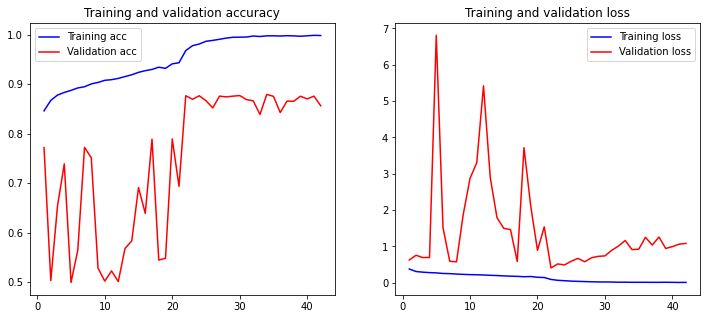

In [37]:
y_probas = model_BLSTM.predict(X_test)
threshold = 0.5
y_predict = np.where(y_probas > threshold, 1, 0)
print(classification_report(y_test, y_predict))
plot_history(history_BLSTM)

              precision    recall  f1-score   support

           0       0.81      0.92      0.86      1778
           1       0.90      0.79      0.84      1778

    accuracy                           0.85      3556
   macro avg       0.86      0.85      0.85      3556
weighted avg       0.86      0.85      0.85      3556



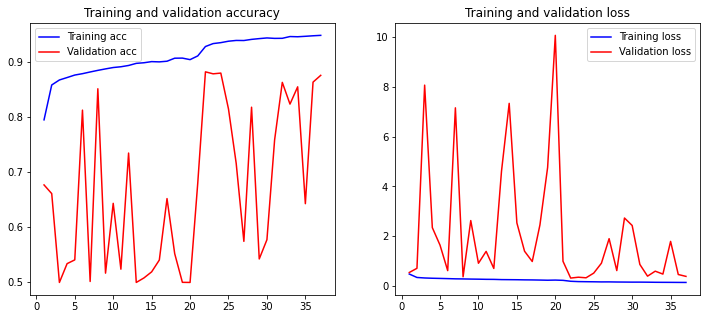

In [12]:
y_probas = model_BLSTM.predict(X_test)
threshold = 0.5
y_predict = np.where(y_probas > threshold, 1, 0)
print(classification_report(y_test, y_predict))
plot_history(history_BLSTM)

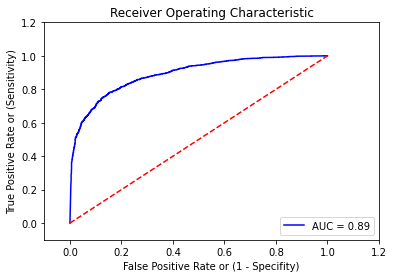

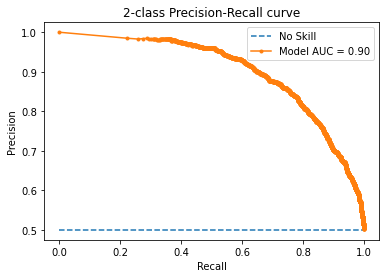

In [40]:
create_roc_curve(y_test,y_probas)
# plot precision-recall curves
plot_pr_curve(y_test, y_probas)

In [19]:
model_BLSTM.save("/mnt/vdb/thesis/best_model_BLSTM.V5.pssm.hdf")


INFO:tensorflow:Assets written to: /mnt/vdb/thesis/best_model_BLSTM.V5.pssm.hdf/assets


/home/ubuntu/miniconda3/envs/py3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/miniconda3/envs/py3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/miniconda3/envs/py3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.50      1.00      0.67      1778
           1       0.00      0.00      0.00      1778

    accuracy                           0.50      3556
   macro avg       0.25      0.50      0.33      3556
weighted avg       0.25      0.50      0.33      3556



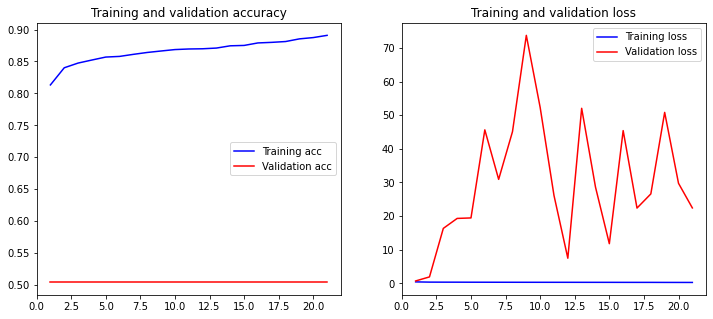

In [51]:
# set9 PSSM
y_probas = model_BLSTM.predict(X_test)
threshold = 0.5
y_predict = np.where(y_probas > threshold, 1, 0)
print(classification_report(y_test, y_predict))
plot_history(history_BLSTM)

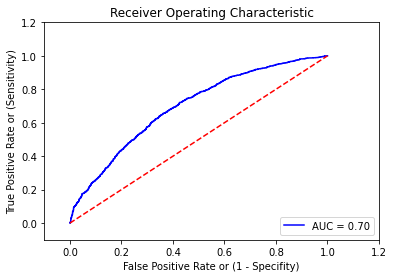

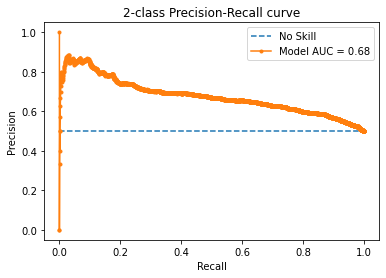

In [48]:
create_roc_curve(y_test,y_probas)
# plot precision-recall curves
plot_pr_curve(y_test, y_probas)

In [18]:
# PSSM

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score


inputs = np.concatenate((X_train, X_val), axis=0)
targets = np.concatenate((y_train, y_val), axis=0)
# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []
_precision = []
_recal = []
_f1 = []
_auc_pr = []
_roc_pr = []
# Define the K-fold Cross Validator
kfold = KFold(n_splits=5, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train_index, test_index  in kfold.split(inputs, targets):
    
    X_train= inputs[train_index]
    y_train= targets[train_index]
    X_val=  inputs[test_index]
    y_val = targets[test_index]
    # Early Stopping
    es = EarlyStopping(monitor='val_loss', patience=15, verbose=1)

    #learning rate decay
    lr_scheduler = LearningRateScheduler(lr_schedule)
    model = create_Modelbaseline_pssm()
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model
    history = model.fit(X_train, y_train, epochs=100,batch_size=128,
                        validation_data=(X_val, y_val),
                        callbacks=[es, lr_scheduler], verbose=0)

    # Generate generalization metrics
    scores = model.evaluate(X_test, y_test, verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    
    # predict probabilities for test set
    y_probas = model.predict(X_test)
    threshold = 0.5
    y_predict = np.where(y_probas > threshold, 1, 0)

    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(y_predict, y_test)
    print('Accuracy: %f' % accuracy)
    # precision tp / (tp + fp)
    precision = (precision_score(y_predict,y_test, pos_label= 1)+precision_score(y_predict,y_test , pos_label= 0))*0.5
    print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = (recall_score(y_predict,y_test, pos_label= 1)+recall_score(y_predict,y_test , pos_label= 0))*0.5
    print('Recall: %f' % recall)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 =  (f1_score(y_predict,y_test, pos_label= 1)+f1_score(y_predict,y_test , pos_label= 0))*0.5
    print('F1 score: %f' % f1)
    
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])  
    _precision.append(precision * 100)  
    _recal.append(recall * 100)  
    _f1.append(f1 * 100)  
 
    # Increase fold number
    fold_no = fold_no + 1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Pecision: {np.mean(_precision)} (+- {np.std(_precision)})')
print(f'> Recall: {np.mean(_recal)} (+- {np.std(_recal)})')
print(f'> F1: {np.mean(_f1)} (+- {np.std(_f1)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Training for fold 1 ...
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
Epoch 00016: early stopping
Score for fold 1: loss of 52.171844482421875; accuracy of 50.0%
Accuracy: 0.500000
Precision: 0.500000
Recall: 0.250000
F1 score: 0.333333


/home/ubuntu/miniconda3/envs/py3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


------------------------------------------------------------------------
Training for fold 2 ...
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
Epoch 00016: early stopping
Score for fold 2: loss of 32.25640106201172; accuracy of 50.0%
Accuracy: 0.500000
Precision: 0.500000
Recall: 0.250000
F1 score: 0.333333


/home/ubuntu/miniconda3/envs/py3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


------------------------------------------------------------------------
Training for fold 3 ...
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
Epoch 00020: early stopping
Score for fold 3: loss of 19.816286087036133; accuracy of 50.0%
Accuracy: 0.500000
Precision: 0.500000
Recall: 0.250000
F1 score: 0.333333


/home/ubuntu/miniconda3/envs/py3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


------------------------------------------------------------------------
Training for fold 4 ...
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.0001
 Learning rate:  0.0001
 Learning rate:  0.0001
 Learning rate:  0.0001
 Learning rate:  0.0001
 Learning rate:  0.0001
 Learning rate:  0.0001
 Learning rate:  0.0001
 Learning rate:  0.0001
 Learning rate:  0.0001
 Learning rate:  0.0001
 Learning rate:  0.0001
 Learning rate:  0.0001
 Learning rate:  0.0001
 Learning rate:  0.0001
 Learning rate:  0.0001
 Learning rate:  0.0001
Epoch 00038:

/home/ubuntu/miniconda3/envs/py3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


------------------------------------------------------------------------
Training for fold 5 ...
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.0001
 Learning rate:  0.0001
 Learning rate:  0.0001
 Learning rate:  0.0001
 Learning rate:  0.0001
 Learning rate:  0.0001
 Learning rate:  0.0001
 Learning rate:  0.0001
 Learning rate:  0.0001
 Learning rate:  0.0001
 Learning rate:  0.0001
 Learning rate:  0.0001
 Learning rate:  0.0001
 Learning rate:  0.0001
 Learning rate:  0.0001
 Learning rate:  0.0001
Epoch 00037: early stopping
Score fo

In [21]:
## jax

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score


inputs = np.concatenate((X_train, X_val), axis=0)
targets = np.concatenate((y_train, y_val), axis=0)
# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []
_precision = []
_recal = []
_f1 = []
_auc_pr = []
_roc_pr = []
# Define the K-fold Cross Validator
kfold = KFold(n_splits=5, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train_index, test_index  in kfold.split(inputs, targets):
    
    X_train= inputs[train_index]
    y_train= targets[train_index]
    X_val=  inputs[test_index]
    y_val = targets[test_index]
    # Early Stopping
    es = EarlyStopping(monitor='val_loss', patience=15, verbose=1)

    #learning rate decay
    lr_scheduler = LearningRateScheduler(lr_schedule)
    model = create_Modelbaseline_jax()
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model
    history = model.fit(X_train, y_train, epochs=100,batch_size=128,
                        validation_data=(X_val, y_val),
                        callbacks=[es, lr_scheduler], verbose=0)

    # Generate generalization metrics
    scores = model.evaluate(X_test, y_test, verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    
    # predict probabilities for test set
    y_probas = model.predict(X_test)
    threshold = 0.5
    y_predict = np.where(y_probas > threshold, 1, 0)

    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(y_predict, y_test)
    print('Accuracy: %f' % accuracy)
    # precision tp / (tp + fp)
    precision = (precision_score(y_predict,y_test, pos_label= 1)+precision_score(y_predict,y_test , pos_label= 0))*0.5
    print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = (recall_score(y_predict,y_test, pos_label= 1)+recall_score(y_predict,y_test , pos_label= 0))*0.5
    print('Recall: %f' % recall)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 =  (f1_score(y_predict,y_test, pos_label= 1)+f1_score(y_predict,y_test , pos_label= 0))*0.5
    print('F1 score: %f' % f1)
    
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])  
    _precision.append(precision * 100)  
    _recal.append(recall * 100)  
    _f1.append(f1 * 100)  
 
    # Increase fold number
    fold_no = fold_no + 1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Pecision: {np.mean(_precision)} (+- {np.std(_precision)})')
print(f'> Recall: {np.mean(_recal)} (+- {np.std(_recal)})')
print(f'> F1: {np.mean(_f1)} (+- {np.std(_f1)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Training for fold 1 ...
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
Epoch 00021: early stopping
Score for fold 1: loss of 2.8184731006622314; accuracy of 58.80202651023865%
Accuracy: 0.588020
Precision: 0.588020
Recall: 0.716185
F1 score: 0.516335
------------------------------------------------------------------------
Training for fold 2 ...
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Learning rate:  0.001
 Lear

## SET 10

In [9]:
import pickle5 as pickle
with open( "/mnt/vdb/thesis/trainingset2/set10/jax/AMPNonAMP.reps", 'rb') as file:
    AMPNonAMP_df = pickle.load(file)
with open( "/mnt/vdb/thesis/trainingset2/benchmark_set/jax/AMPNonAMP.benchmark_set.reps", 'rb') as file:
    benchmark_AMPs_df = pickle.load(file)
    
X_train = np.array(AMPNonAMP_df['reps'].to_list())
y_train = np.array(AMPNonAMP_df['class'].to_list())
X_test = np.array(benchmark_AMPs_df["reps"].to_list())
y_test = np.array( benchmark_AMPs_df["class"].to_list())

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))
print(X_train.shape)
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
print(X_test.shape)
X_val = np.reshape(X_val,(X_val.shape[0],X_val.shape[1],1))
print(X_val.shape)

(35470, 1900, 1)
(3556, 1900, 1)
(8868, 1900, 1)


In [10]:
model_BLSTM = create_Modelbaseline_jax()

# Early Stopping
es = EarlyStopping(monitor='val_loss', patience=20, verbose=1)

history_BLSTM = model_BLSTM.fit(X_train, y_train, epochs=100, batch_size=256, validation_data=(X_val, y_val),
                     callbacks=[es,lr_scheduler], verbose=1)

 Learning rate:  0.001
Epoch 1/100
139/139 [==============================] - 18s 126ms/step - loss: 0.4044 - accuracy: 0.8362 - val_loss: 0.6743 - val_accuracy: 0.6848
 Learning rate:  0.001
Epoch 2/100
139/139 [==============================] - 17s 121ms/step - loss: 0.3071 - accuracy: 0.8632 - val_loss: 0.6446 - val_accuracy: 0.5032
 Learning rate:  0.001
Epoch 3/100
139/139 [==============================] - 18s 127ms/step - loss: 0.2900 - accuracy: 0.8739 - val_loss: 0.4918 - val_accuracy: 0.8364
 Learning rate:  0.001
Epoch 4/100
139/139 [==============================] - 17s 120ms/step - loss: 0.2803 - accuracy: 0.8779 - val_loss: 0.3821 - val_accuracy: 0.8328
 Learning rate:  0.001
Epoch 5/100
139/139 [==============================] - 16s 116ms/step - loss: 0.2712 - accuracy: 0.8821 - val_loss: 0.3849 - val_accuracy: 0.8447
 Learning rate:  0.001
Epoch 6/100
139/139 [==============================] - 16s 116ms/step - loss: 0.2606 - accuracy: 0.8869 - val_loss: 0.4426 - val_acc

              precision    recall  f1-score   support

           0       0.76      0.87      0.81      1778
           1       0.84      0.73      0.78      1778

    accuracy                           0.80      3556
   macro avg       0.80      0.80      0.80      3556
weighted avg       0.80      0.80      0.80      3556



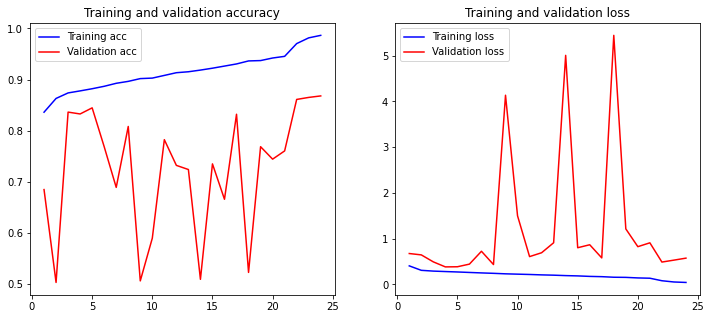

In [11]:
# C0.4
y_probas = model_BLSTM.predict(X_test)
threshold = 0.5
y_predict = np.where(y_probas > threshold, 1, 0)
print(classification_report(y_test, y_predict))
plot_history(history_BLSTM)

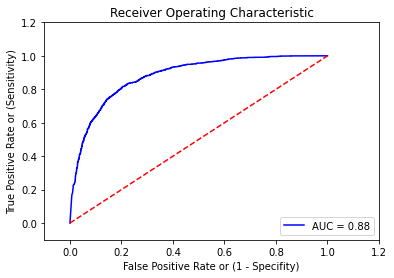

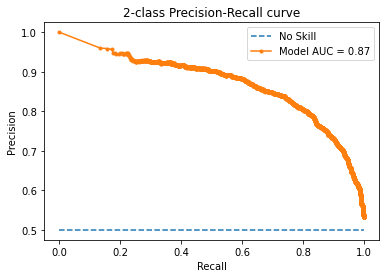

In [9]:
create_roc_curve(y_test,y_probas)
# plot precision-recall curves
plot_pr_curve(y_test, y_probas)

In [12]:
model_BLSTM.save("/mnt/vdb/thesis/best_model_BLSTM.V5.set_10.hdf")


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /mnt/vdb/thesis/best_model_BLSTM.V5.set_10.hdf/assets


In [7]:
# C 0.5
model_BLSTM = create_Modelbaseline_jax()

# Early Stopping
es = EarlyStopping(monitor='val_loss', patience=20, verbose=1)

history_BLSTM = model_BLSTM.fit(X_train, y_train, epochs=100, batch_size=256, validation_data=(X_val, y_val),
                     callbacks=[es,lr_scheduler], verbose=1)

 Learning rate:  0.001
Epoch 1/100
141/141 [==============================] - 17s 124ms/step - loss: 0.4086 - accuracy: 0.8340 - val_loss: 0.6860 - val_accuracy: 0.4997
 Learning rate:  0.001
Epoch 2/100
141/141 [==============================] - 17s 121ms/step - loss: 0.3089 - accuracy: 0.8645 - val_loss: 0.6125 - val_accuracy: 0.6191
 Learning rate:  0.001
Epoch 3/100
141/141 [==============================] - 17s 117ms/step - loss: 0.2900 - accuracy: 0.8739 - val_loss: 0.5944 - val_accuracy: 0.6050
 Learning rate:  0.001
Epoch 4/100
141/141 [==============================] - 17s 121ms/step - loss: 0.2867 - accuracy: 0.8741 - val_loss: 0.9113 - val_accuracy: 0.5689
 Learning rate:  0.001
Epoch 5/100
141/141 [==============================] - 16s 117ms/step - loss: 0.2739 - accuracy: 0.8798 - val_loss: 0.5664 - val_accuracy: 0.7147
 Learning rate:  0.001
Epoch 6/100
141/141 [==============================] - 17s 120ms/step - loss: 0.2632 - accuracy: 0.8843 - val_loss: 0.6809 - val_acc

              precision    recall  f1-score   support

           0       0.72      0.86      0.78      1778
           1       0.82      0.67      0.74      1778

    accuracy                           0.76      3556
   macro avg       0.77      0.76      0.76      3556
weighted avg       0.77      0.76      0.76      3556



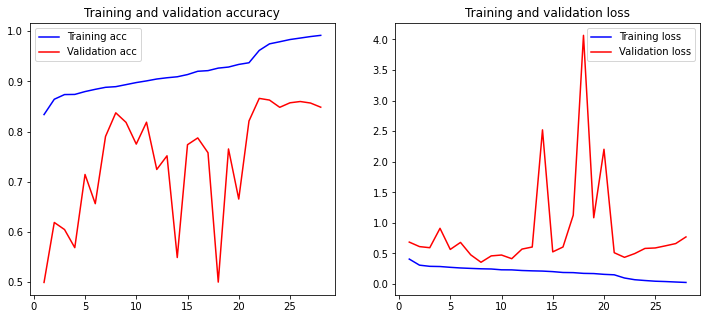

In [8]:
y_probas = model_BLSTM.predict(X_test)
threshold = 0.5
y_predict = np.where(y_probas > threshold, 1, 0)
print(classification_report(y_test, y_predict))
plot_history(history_BLSTM)